In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
from matplotlib import pyplot as plt
from torchviz import make_dot # net visualization
import numpy as np
from tqdm import tqdm
import random
import collections

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)

### Загрузка данных

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 40000
Images shape: (32, 32, 3)
Number of valid samples: 10000
Images shape: (32, 32, 3)
Number of test samples: 10000
Images shape: (32, 32, 3)


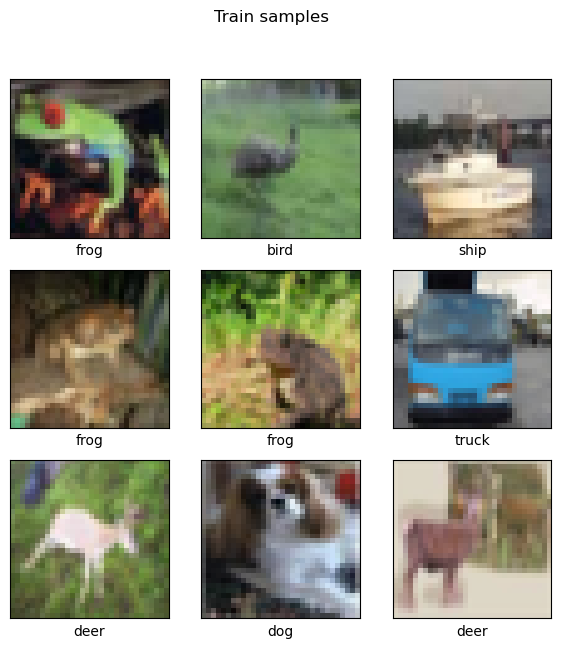

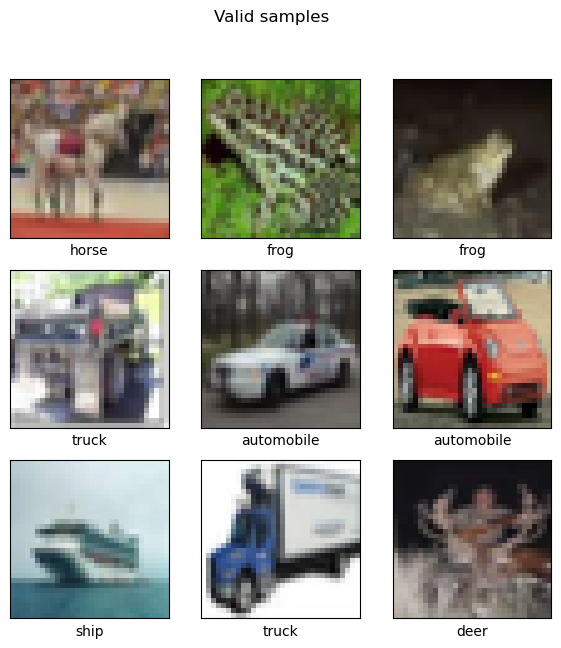

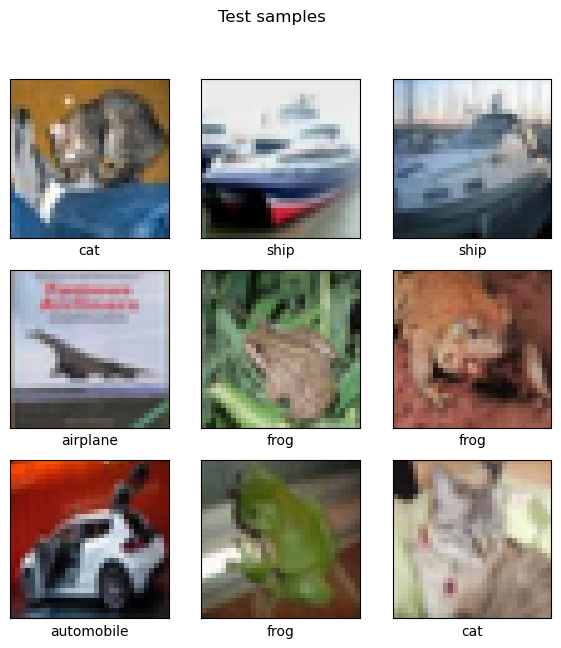

In [3]:
dir_name = os.getcwd()
batch_size = 128

class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.class_to_idx = subset.dataset.class_to_idx


        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

def transform_to_image(image):
    # [Normalize] output = (input - mean) / std
    image = (image - (-train_mean / train_std)) / (1.0 / train_std)
    image = image.clip(0, 1)
    return image

def show_images(images, title):
    num_showed_imgs_x = 3
    num_showed_imgs_y = 3

    figsize = (7, 7)
    fig, axes = plt.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    print(f'Images shape: {images[0][0].numpy().transpose(1,2,0).shape}')
    plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
    classes = {val : key for key, val in images.class_to_idx.items()}
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0) #.squeeze(axis = 2)
        label = classes[images[i][1]]
        ax.set_xlabel(label)
        ax.imshow(transform_to_image(img))

train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = None
)

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_mean = np.mean(train_dataset.dataset.data[train_dataset.indices], axis=tuple(range(train_dataset.dataset.data.ndim-1))) / 255
train_std = np.std(train_dataset.dataset.data[train_dataset.indices], axis=tuple(range(train_dataset.dataset.data.ndim-1))) / 255

transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(train_mean.tolist(), train_std.tolist()), # means and stds
])
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(train_mean.tolist(), train_std.tolist()), # means and stds
])

train_dataset = DatasetFromSubset(train_dataset, transform_train)
valid_dataset = DatasetFromSubset(valid_dataset, transform_test)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = transform_test
)

print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of valid samples: {}'.format(len(valid_dataset)))
show_images(valid_dataset, 'Valid samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size = batch_size, shuffle = False
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

### Построение архитектуры сверточной сети

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = torch.nn.Sequential(collections.OrderedDict([
            # 3 x 32 x 32
          ('conv1', torch.nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1
            )),
            # 16 x ((32-3+2)/1+1) x ((32-3+2)/1+1) = 16 x 32 x 32
          ('relu1', torch.nn.ReLU()),
          ('conv2', torch.nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1
            )),
            # 32 x 32 x 32
          ('batchNorm1', torch.nn.BatchNorm2d(32)),
          ('relu2', torch.nn.ReLU()),
          ('pool1', torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding=1)),
            # 32 x ((32-3+2) / 2 + 1) x ((32-3+2) / 2 + 1) = 32 x 16 x 16
          ('conv3', torch.nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
            )),
            # 64 x 16 x 16
          ('batchNorm2', torch.nn.BatchNorm2d(64)),
          ('relu3', torch.nn.ReLU()),
          ('pool2', torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding=1)),
            # 64 x ((16-3+2) / 2 + 1) x ((16-3+2) / 2 + 1) = 64 x 8 x 8
          ('conv4', torch.nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
            )),
            # 128 x 8 x 8
          ('relu4', torch.nn.ReLU()),
          ('conv5', torch.nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1
            )),
            # 256 x 8 x 8
          ('batchNorm3', torch.nn.BatchNorm2d(256)),
          ('relu5', torch.nn.ReLU()),
        ]))
        self.classifier = torch.nn.Sequential(collections.OrderedDict([
          ('dropout', torch.nn.Dropout(0.2)),
          ('fc', torch.nn.Linear(256 * 8 * 8, 10))
            # (softmax включается в вычисление кросс-энтропии)
        ]))

    def forward(self, x):
        out = self.features(x)
        # Изменение формата хранения тензора из (B, C, W, H) в (B, C*W*H)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

model = Net()
model

Net(
  (features): Sequential(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchNorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU()
    (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchNorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu5): ReLU()
 


#### Used nets

##### Net 1

<p>
Net( <br>
  (conv): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1)) <br>
  (activation): ReLU() <br>
  (pooling): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False) <br>
  (linear): Linear(in_features=8410, out_features=10, bias=True) <br>
)
</p>

##### Net 2

<p>
Net( <br>
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1)) <br>
  (conv2): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1)) <br>
  (activation): ReLU() <br>
  (pooling): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False) <br>
  (fc1): Linear(in_features=7290, out_features=128, bias=True) <br>
  (fc2): Linear(in_features=128, out_features=64, bias=True) <br>
  (fc3): Linear(in_features=64, out_features=10, bias=True) <br>
)
</p>

##### Net 3

<p>
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) <br>
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) <br>
  (relu): ReLU() <br>
  (fc1): Linear(in_features=4096, out_features=32, bias=True) <br>
  (fc2): Linear(in_features=32, out_features=16, bias=True) <br>
  (fc3): Linear(in_features=16, out_features=10, bias=True) <br>
)
</p>

##### Net 4

<p>
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (relu): ReLU() <br>
  (fc1): Linear(in_features=65536, out_features=32, bias=True) <br>
  (fc2): Linear(in_features=32, out_features=16, bias=True) <br>
  (fc3): Linear(in_features=16, out_features=10, bias=True) <br>
) 
</p>

##### Net 5

<p>
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) <br>
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) <br>
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (relu): ReLU() <br>
  (fc1): Linear(in_features=16384, out_features=32, bias=True) <br>
  (fc2): Linear(in_features=32, out_features=16, bias=True) <br>
  (fc3): Linear(in_features=16, out_features=10, bias=True) <br>
) 
</p>

##### Net 6

<p>
Net(
  (dropout): Dropout(p=0.2, inplace=False) <br> 
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) <br>
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) <br>
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (relu): ReLU() <br>
  (fc1): Linear(in_features=16384, out_features=32, bias=True) <br>
  (fc2): Linear(in_features=32, out_features=16, bias=True) <br>
  (fc3): Linear(in_features=16, out_features=10, bias=True) <br>
)
</p>

##### Net 7

<p>
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (dropout1): Dropout(p=0.2, inplace=False) <br>
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) <br>
  (dropout2): Dropout(p=0.2, inplace=False) <br>
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) <br>
  (dropout3): Dropout(p=0.2, inplace=False) <br>
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (relu): ReLU() <br>
  (fc1): Linear(in_features=16384, out_features=32, bias=True) <br>
  (dropout4): Dropout(p=0.2, inplace=False) <br>
  (fc2): Linear(in_features=32, out_features=16, bias=True) <br>
  (fc3): Linear(in_features=16, out_features=10, bias=True) <br>
) 
</p>

##### Net 8

<p>
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (batchNorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) <br>
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) <br>
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) <br>
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) <br>
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
  (batchNorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) <br>
  (relu): ReLU() <br>
  (fc1): Linear(in_features=16384, out_features=32, bias=True) <br>
  (fc2): Linear(in_features=32, out_features=16, bias=True) <br>
  (fc3): Linear(in_features=16, out_features=10, bias=True) <br>
) 
</p>

##### Net 9, 10

<p>
Net( <br>
  (features): Sequential( <br>
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
    (relu1): ReLU() <br>
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
    (batchNorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) <br>
    (relu2): ReLU() <br>
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) <br>
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
    (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) <br>
    (relu3): ReLU() <br>
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) <br>
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
    (relu4): ReLU() <br>
    (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) <br>
    (batchNorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) <br>
    (relu5): ReLU() <br>
  ) <br>
  (classifier): Sequential( <br>
    (dropout): Dropout(p=0.2, inplace=False) <br>
    (fc): Linear(in_features=16384, out_features=10, bias=True) <br>
  )
)
</p>

#### Визуализация

In [5]:
dataiter = iter(test_data_loader)
images, labels = next(dataiter)
out = model(images)
make_dot(out, params=dict(list(model.named_parameters()))).render('Net', format='png')

'Net.png'

### Обучение модели

In [6]:
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

In [7]:
%%time

model_name = 'Net_10' # for model saving

learning_rate = 0.1
momentum = 0.9
weight_decay = 5e-4
num_epochs = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, verbose=True)

pbar = tqdm(range(num_epochs))
last_epoch_time = 0

min_valid_loss = None
epochs_valid_loss = 15
iters_valid_loss = 0
best_valid_accuracy = None

print('#############################################################################################')
print(f'[Training parameters]\n\tepochs = {num_epochs},\n\tlr = {learning_rate},\n\tmomentum = {momentum},\n\tweight_decay = {weight_decay},\n\tloss = {loss_function},\n\toptimizer = {optimizer},\n\tscheduler = {scheduler},\n\tdevice = {device}')
print('#############################################################################################')

for epoch in pbar:
    train_loss = 0.0
    model.train()
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_data_loader)
    train_accuracy = get_accuracy(train_data_loader, model).item()

    valid_loss = 0.0
    model.eval()
    for i, (vimages, vlabels) in enumerate(valid_data_loader):
        vimages = vimages.to(device)
        vlabels = vlabels.to(device)

        voutputs = model(vimages)
        loss = loss_function(voutputs, vlabels)
        valid_loss += loss.item()
    valid_loss = valid_loss / len(valid_data_loader)
    valid_accuracy = get_accuracy(valid_data_loader, model).item()
    scheduler.step()

    print(f'Epoch[{epoch}]:')
    print(f'\ttrain_loss = {round(train_loss, 5)}, train_accuracy = {round(train_accuracy, 8)}')
    print(f'\tvalid_loss = {round(valid_loss, 5)}, valid_accuracy = {round(valid_accuracy, 8)}')
    print(f'\ttime = {round(pbar.format_dict["elapsed"] - last_epoch_time, 2)} s')
    if min_valid_loss is None or min_valid_loss > valid_loss:
        print(f'Validation loss decreased({None if min_valid_loss is None else round(min_valid_loss, 5)}--->{round(valid_loss, 5)}) \t Saving The Model')
        min_valid_loss = valid_loss
        valid_train_loss = train_loss # relative to valid loss
        valid_train_accuracy = train_accuracy # relative to valid loss
        best_valid_accuracy = valid_accuracy
        # Saving State Dict
        torch.save(model.state_dict(), f'{model_name}_model.pth')
        iters_valid_loss = 0
    else:
        iters_valid_loss += 1
    if (iters_valid_loss == epochs_valid_loss):
        print(f"Validation loss didn't decrease for {epochs_valid_loss} epochs ---> model training stopped")
        break
    last_epoch_time = pbar.format_dict["elapsed"]

# log result
file = open(f'{model_name}_model.log', 'w')
file.write(f'[{model_name}]\n\t{model}\n\tvalid training loss: {round(valid_train_loss, 5)}\n\tvalid training accuracy {round(valid_train_accuracy, 8)}\n\tmin validation loss: {round(min_valid_loss, 5)},\n\tbest validation accuracy: {round(best_valid_accuracy, 8)},\n\ttime: {pbar.format_dict["elapsed"]} s')
file.close()

print(f'[Finished training]\n\tvalid training loss: {round(valid_train_loss, 5)}\n\tvalid training accuracy {round(valid_train_accuracy, 8)}\n\tmin validation loss: {round(min_valid_loss, 5)},\n\tbest validation accuracy: {round(best_valid_accuracy, 8)}')

Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/100 [00:00<?, ?it/s]

#############################################################################################
[Training parameters]
	epochs = 100,
	lr = 0.1,
	momentum = 0.9,
	weight_decay = 0.0005,
	loss = CrossEntropyLoss(),
	optimizer = SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
),
	scheduler = <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000023CD0328F70>,
	device = cuda:0
#############################################################################################


  1%|          | 1/100 [00:22<36:39, 22.21s/it]

Adjusting learning rate of group 0 to 9.9975e-02.
Epoch[0]:
	train_loss = 3.41241, train_accuracy = 0.190725
	valid_loss = 2.18821, valid_accuracy = 0.184
	time = 22.2 s
Validation loss decreased(None--->2.18821) 	 Saving The Model


  2%|▏         | 2/100 [00:39<31:54, 19.53s/it]

Adjusting learning rate of group 0 to 9.9901e-02.
Epoch[1]:
	train_loss = 2.08148, train_accuracy = 0.33004999
	valid_loss = 1.85747, valid_accuracy = 0.32789999
	time = 17.64 s
Validation loss decreased(2.18821--->1.85747) 	 Saving The Model


  3%|▎         | 3/100 [00:57<30:12, 18.69s/it]

Adjusting learning rate of group 0 to 9.9778e-02.
Epoch[2]:
	train_loss = 1.82579, train_accuracy = 0.3915
	valid_loss = 1.6388, valid_accuracy = 0.3996
	time = 17.67 s
Validation loss decreased(1.85747--->1.6388) 	 Saving The Model


  4%|▍         | 4/100 [01:15<29:21, 18.35s/it]

Adjusting learning rate of group 0 to 9.9606e-02.
Epoch[3]:
	train_loss = 1.66441, train_accuracy = 0.43629998
	valid_loss = 1.54034, valid_accuracy = 0.42569998
	time = 17.83 s
Validation loss decreased(1.6388--->1.54034) 	 Saving The Model


  5%|▌         | 5/100 [01:33<28:45, 18.16s/it]

Adjusting learning rate of group 0 to 9.9384e-02.
Epoch[4]:
	train_loss = 1.52925, train_accuracy = 0.48232499
	valid_loss = 1.43387, valid_accuracy = 0.4788
	time = 17.84 s
Validation loss decreased(1.54034--->1.43387) 	 Saving The Model


  6%|▌         | 6/100 [01:50<28:13, 18.02s/it]

Adjusting learning rate of group 0 to 9.9114e-02.
Epoch[5]:
	train_loss = 1.37974, train_accuracy = 0.56762499
	valid_loss = 1.21206, valid_accuracy = 0.5632
	time = 17.71 s
Validation loss decreased(1.43387--->1.21206) 	 Saving The Model


  7%|▋         | 7/100 [02:08<27:53, 18.00s/it]

Adjusting learning rate of group 0 to 9.8796e-02.
Epoch[6]:
	train_loss = 1.23722, train_accuracy = 0.61799997
	valid_loss = 1.08879, valid_accuracy = 0.61509997
	time = 17.95 s
Validation loss decreased(1.21206--->1.08879) 	 Saving The Model


  8%|▊         | 8/100 [02:26<27:36, 18.00s/it]

Adjusting learning rate of group 0 to 9.8429e-02.
Epoch[7]:
	train_loss = 1.11466, train_accuracy = 0.58377498
	valid_loss = 1.17871, valid_accuracy = 0.57919997
	time = 18.02 s


  9%|▉         | 9/100 [02:44<27:08, 17.90s/it]

Adjusting learning rate of group 0 to 9.8015e-02.
Epoch[8]:
	train_loss = 1.00931, train_accuracy = 0.66644996
	valid_loss = 0.9926, valid_accuracy = 0.6552
	time = 17.67 s
Validation loss decreased(1.08879--->0.9926) 	 Saving The Model


 10%|█         | 10/100 [03:02<26:42, 17.81s/it]

Adjusting learning rate of group 0 to 9.7553e-02.
Epoch[9]:
	train_loss = 0.93324, train_accuracy = 0.6225
	valid_loss = 1.1411, valid_accuracy = 0.60890001
	time = 17.6 s


 11%|█         | 11/100 [03:19<26:16, 17.72s/it]

Adjusting learning rate of group 0 to 9.7044e-02.
Epoch[10]:
	train_loss = 0.88807, train_accuracy = 0.67864996
	valid_loss = 0.95776, valid_accuracy = 0.66619998
	time = 17.52 s
Validation loss decreased(0.9926--->0.95776) 	 Saving The Model


 12%|█▏        | 12/100 [03:37<25:58, 17.71s/it]

Adjusting learning rate of group 0 to 9.6489e-02.
Epoch[11]:
	train_loss = 0.85269, train_accuracy = 0.69942498
	valid_loss = 0.89551, valid_accuracy = 0.68759996
	time = 17.69 s
Validation loss decreased(0.95776--->0.89551) 	 Saving The Model


 13%|█▎        | 13/100 [03:55<25:54, 17.87s/it]

Adjusting learning rate of group 0 to 9.5888e-02.
Epoch[12]:
	train_loss = 0.81537, train_accuracy = 0.71724999
	valid_loss = 0.87294, valid_accuracy = 0.6972
	time = 18.22 s
Validation loss decreased(0.89551--->0.87294) 	 Saving The Model


 14%|█▍        | 14/100 [04:14<25:58, 18.12s/it]

Adjusting learning rate of group 0 to 9.5241e-02.
Epoch[13]:
	train_loss = 0.79141, train_accuracy = 0.67092496
	valid_loss = 1.04034, valid_accuracy = 0.64899999
	time = 18.7 s


 15%|█▌        | 15/100 [04:31<25:20, 17.89s/it]

Adjusting learning rate of group 0 to 9.4550e-02.
Epoch[14]:
	train_loss = 0.7805, train_accuracy = 0.72955
	valid_loss = 0.85596, valid_accuracy = 0.7101
	time = 17.37 s
Validation loss decreased(0.87294--->0.85596) 	 Saving The Model


 16%|█▌        | 16/100 [04:49<24:49, 17.73s/it]

Adjusting learning rate of group 0 to 9.3815e-02.
Epoch[15]:
	train_loss = 0.76286, train_accuracy = 0.69972497
	valid_loss = 0.90817, valid_accuracy = 0.68589997
	time = 17.36 s


 17%|█▋        | 17/100 [05:06<24:27, 17.68s/it]

Adjusting learning rate of group 0 to 9.3037e-02.
Epoch[16]:
	train_loss = 0.74284, train_accuracy = 0.71754998
	valid_loss = 0.88386, valid_accuracy = 0.69619995
	time = 17.56 s


 18%|█▊        | 18/100 [05:24<24:11, 17.70s/it]

Adjusting learning rate of group 0 to 9.2216e-02.
Epoch[17]:
	train_loss = 0.72381, train_accuracy = 0.70744997
	valid_loss = 0.9412, valid_accuracy = 0.68619996
	time = 17.76 s


 19%|█▉        | 19/100 [05:41<23:50, 17.66s/it]

Adjusting learning rate of group 0 to 9.1354e-02.
Epoch[18]:
	train_loss = 0.70783, train_accuracy = 0.68180001
	valid_loss = 0.99973, valid_accuracy = 0.66079998
	time = 17.55 s


 20%|██        | 20/100 [05:59<23:28, 17.60s/it]

Adjusting learning rate of group 0 to 9.0451e-02.
Epoch[19]:
	train_loss = 0.70469, train_accuracy = 0.678325
	valid_loss = 1.06605, valid_accuracy = 0.66229999
	time = 17.47 s


 21%|██        | 21/100 [06:17<23:13, 17.65s/it]

Adjusting learning rate of group 0 to 8.9508e-02.
Epoch[20]:
	train_loss = 0.68704, train_accuracy = 0.76405001
	valid_loss = 0.74351, valid_accuracy = 0.74419999
	time = 17.74 s
Validation loss decreased(0.85596--->0.74351) 	 Saving The Model


 22%|██▏       | 22/100 [06:34<22:59, 17.69s/it]

Adjusting learning rate of group 0 to 8.8526e-02.
Epoch[21]:
	train_loss = 0.6704, train_accuracy = 0.74879998
	valid_loss = 0.81801, valid_accuracy = 0.7209
	time = 17.78 s


 23%|██▎       | 23/100 [06:52<22:37, 17.63s/it]

Adjusting learning rate of group 0 to 8.7506e-02.
Epoch[22]:
	train_loss = 0.6708, train_accuracy = 0.75132495
	valid_loss = 0.78352, valid_accuracy = 0.7281
	time = 17.5 s


 24%|██▍       | 24/100 [07:09<22:13, 17.55s/it]

Adjusting learning rate of group 0 to 8.6448e-02.
Epoch[23]:
	train_loss = 0.66539, train_accuracy = 0.77309996
	valid_loss = 0.74798, valid_accuracy = 0.74479997
	time = 17.36 s


 25%|██▌       | 25/100 [07:27<21:50, 17.48s/it]

Adjusting learning rate of group 0 to 8.5355e-02.
Epoch[24]:
	train_loss = 0.64965, train_accuracy = 0.76909995
	valid_loss = 0.74321, valid_accuracy = 0.74680001
	time = 17.31 s
Validation loss decreased(0.74351--->0.74321) 	 Saving The Model


 26%|██▌       | 26/100 [07:44<21:29, 17.43s/it]

Adjusting learning rate of group 0 to 8.4227e-02.
Epoch[25]:
	train_loss = 0.63389, train_accuracy = 0.70122498
	valid_loss = 0.93598, valid_accuracy = 0.68199998
	time = 17.32 s


 27%|██▋       | 27/100 [08:02<21:17, 17.50s/it]

Adjusting learning rate of group 0 to 8.3066e-02.
Epoch[26]:
	train_loss = 0.62481, train_accuracy = 0.751975
	valid_loss = 0.7853, valid_accuracy = 0.7299
	time = 17.65 s


 28%|██▊       | 28/100 [08:19<21:03, 17.55s/it]

Adjusting learning rate of group 0 to 8.1871e-02.
Epoch[27]:
	train_loss = 0.62555, train_accuracy = 0.74829996
	valid_loss = 0.82399, valid_accuracy = 0.72189999
	time = 17.66 s


 29%|██▉       | 29/100 [08:37<20:46, 17.55s/it]

Adjusting learning rate of group 0 to 8.0645e-02.
Epoch[28]:
	train_loss = 0.62443, train_accuracy = 0.78732497
	valid_loss = 0.69557, valid_accuracy = 0.76029998
	time = 17.56 s
Validation loss decreased(0.74321--->0.69557) 	 Saving The Model


 30%|███       | 30/100 [08:54<20:25, 17.50s/it]

Adjusting learning rate of group 0 to 7.9389e-02.
Epoch[29]:
	train_loss = 0.61409, train_accuracy = 0.78284997
	valid_loss = 0.73116, valid_accuracy = 0.7507
	time = 17.39 s


 31%|███       | 31/100 [09:12<20:08, 17.52s/it]

Adjusting learning rate of group 0 to 7.8104e-02.
Epoch[30]:
	train_loss = 0.60504, train_accuracy = 0.78352499
	valid_loss = 0.72219, valid_accuracy = 0.75659996
	time = 17.55 s


 32%|███▏      | 32/100 [09:29<19:50, 17.51s/it]

Adjusting learning rate of group 0 to 7.6791e-02.
Epoch[31]:
	train_loss = 0.59766, train_accuracy = 0.75897497
	valid_loss = 0.78269, valid_accuracy = 0.73159999
	time = 17.49 s


 33%|███▎      | 33/100 [09:47<19:31, 17.48s/it]

Adjusting learning rate of group 0 to 7.5452e-02.
Epoch[32]:
	train_loss = 0.58845, train_accuracy = 0.78735
	valid_loss = 0.70977, valid_accuracy = 0.75629997
	time = 17.42 s


 34%|███▍      | 34/100 [10:04<19:19, 17.57s/it]

Adjusting learning rate of group 0 to 7.4088e-02.
Epoch[33]:
	train_loss = 0.58266, train_accuracy = 0.67752498
	valid_loss = 1.08694, valid_accuracy = 0.662
	time = 17.76 s


 35%|███▌      | 35/100 [10:22<19:02, 17.58s/it]

Adjusting learning rate of group 0 to 7.2700e-02.
Epoch[34]:
	train_loss = 0.57962, train_accuracy = 0.76394999
	valid_loss = 0.78963, valid_accuracy = 0.73210001
	time = 17.6 s


 36%|███▌      | 36/100 [10:40<18:47, 17.61s/it]

Adjusting learning rate of group 0 to 7.1289e-02.
Epoch[35]:
	train_loss = 0.57931, train_accuracy = 0.71012497
	valid_loss = 0.97187, valid_accuracy = 0.67939997
	time = 17.7 s


 37%|███▋      | 37/100 [10:57<18:26, 17.56s/it]

Adjusting learning rate of group 0 to 6.9857e-02.
Epoch[36]:
	train_loss = 0.56658, train_accuracy = 0.77202499
	valid_loss = 0.78327, valid_accuracy = 0.73890001
	time = 17.44 s


 38%|███▊      | 38/100 [11:15<18:07, 17.54s/it]

Adjusting learning rate of group 0 to 6.8406e-02.
Epoch[37]:
	train_loss = 0.55287, train_accuracy = 0.77739996
	valid_loss = 0.75877, valid_accuracy = 0.75150001
	time = 17.48 s


 39%|███▉      | 39/100 [11:32<17:48, 17.52s/it]

Adjusting learning rate of group 0 to 6.6937e-02.
Epoch[38]:
	train_loss = 0.54427, train_accuracy = 0.81897497
	valid_loss = 0.62355, valid_accuracy = 0.78289998
	time = 17.47 s
Validation loss decreased(0.69557--->0.62355) 	 Saving The Model


 40%|████      | 40/100 [11:49<17:27, 17.46s/it]

Adjusting learning rate of group 0 to 6.5451e-02.
Epoch[39]:
	train_loss = 0.54087, train_accuracy = 0.81664997
	valid_loss = 0.62328, valid_accuracy = 0.78689998
	time = 17.33 s
Validation loss decreased(0.62355--->0.62328) 	 Saving The Model


 41%|████      | 41/100 [12:07<17:08, 17.44s/it]

Adjusting learning rate of group 0 to 6.3950e-02.
Epoch[40]:
	train_loss = 0.53604, train_accuracy = 0.82852501
	valid_loss = 0.60893, valid_accuracy = 0.79269999
	time = 17.36 s
Validation loss decreased(0.62328--->0.60893) 	 Saving The Model


 42%|████▏     | 42/100 [12:24<16:48, 17.39s/it]

Adjusting learning rate of group 0 to 6.2434e-02.
Epoch[41]:
	train_loss = 0.52523, train_accuracy = 0.77149999
	valid_loss = 0.78822, valid_accuracy = 0.73499995
	time = 17.29 s


 43%|████▎     | 43/100 [12:41<16:28, 17.34s/it]

Adjusting learning rate of group 0 to 6.0907e-02.
Epoch[42]:
	train_loss = 0.51818, train_accuracy = 0.82505
	valid_loss = 0.61296, valid_accuracy = 0.78999996
	time = 17.22 s


 44%|████▍     | 44/100 [12:59<16:17, 17.46s/it]

Adjusting learning rate of group 0 to 5.9369e-02.
Epoch[43]:
	train_loss = 0.51398, train_accuracy = 0.84222496
	valid_loss = 0.58034, valid_accuracy = 0.8035
	time = 17.75 s
Validation loss decreased(0.60893--->0.58034) 	 Saving The Model


 45%|████▌     | 45/100 [13:16<15:59, 17.45s/it]

Adjusting learning rate of group 0 to 5.7822e-02.
Epoch[44]:
	train_loss = 0.51645, train_accuracy = 0.819525
	valid_loss = 0.65617, valid_accuracy = 0.77789998
	time = 17.42 s


 46%|████▌     | 46/100 [13:34<15:42, 17.45s/it]

Adjusting learning rate of group 0 to 5.6267e-02.
Epoch[45]:
	train_loss = 0.50738, train_accuracy = 0.805875
	valid_loss = 0.67524, valid_accuracy = 0.7683
	time = 17.45 s


 47%|████▋     | 47/100 [13:51<15:24, 17.44s/it]

Adjusting learning rate of group 0 to 5.4705e-02.
Epoch[46]:
	train_loss = 0.49418, train_accuracy = 0.83692497
	valid_loss = 0.57724, valid_accuracy = 0.80109996
	time = 17.4 s
Validation loss decreased(0.58034--->0.57724) 	 Saving The Model


 48%|████▊     | 48/100 [14:09<15:08, 17.47s/it]

Adjusting learning rate of group 0 to 5.3140e-02.
Epoch[47]:
	train_loss = 0.48832, train_accuracy = 0.846425
	valid_loss = 0.57217, valid_accuracy = 0.80449998
	time = 17.55 s
Validation loss decreased(0.57724--->0.57217) 	 Saving The Model


 49%|████▉     | 49/100 [14:27<15:02, 17.69s/it]

Adjusting learning rate of group 0 to 5.1571e-02.
Epoch[48]:
	train_loss = 0.48292, train_accuracy = 0.78082496
	valid_loss = 0.76762, valid_accuracy = 0.74369997
	time = 18.2 s


 50%|█████     | 50/100 [14:46<15:07, 18.15s/it]

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch[49]:
	train_loss = 0.47691, train_accuracy = 0.82412499
	valid_loss = 0.63041, valid_accuracy = 0.78310001
	time = 19.21 s


 51%|█████     | 51/100 [15:05<14:59, 18.36s/it]

Adjusting learning rate of group 0 to 4.8429e-02.
Epoch[50]:
	train_loss = 0.46529, train_accuracy = 0.81355
	valid_loss = 0.66786, valid_accuracy = 0.77089995
	time = 18.87 s


 52%|█████▏    | 52/100 [15:24<14:42, 18.38s/it]

Adjusting learning rate of group 0 to 4.6860e-02.
Epoch[51]:
	train_loss = 0.46438, train_accuracy = 0.80577499
	valid_loss = 0.70612, valid_accuracy = 0.76249999
	time = 18.41 s


 53%|█████▎    | 53/100 [15:42<14:22, 18.35s/it]

Adjusting learning rate of group 0 to 4.5295e-02.
Epoch[52]:
	train_loss = 0.45818, train_accuracy = 0.80062497
	valid_loss = 0.70477, valid_accuracy = 0.75819999
	time = 18.3 s


 54%|█████▍    | 54/100 [16:02<14:22, 18.74s/it]

Adjusting learning rate of group 0 to 4.3733e-02.
Epoch[53]:
	train_loss = 0.45427, train_accuracy = 0.83857501
	valid_loss = 0.6169, valid_accuracy = 0.78849995
	time = 19.65 s


 55%|█████▌    | 55/100 [16:21<14:12, 18.95s/it]

Adjusting learning rate of group 0 to 4.2178e-02.
Epoch[54]:
	train_loss = 0.43747, train_accuracy = 0.82477498
	valid_loss = 0.63724, valid_accuracy = 0.78859997
	time = 19.43 s


 56%|█████▌    | 56/100 [16:41<14:02, 19.16s/it]

Adjusting learning rate of group 0 to 4.0631e-02.
Epoch[55]:
	train_loss = 0.43743, train_accuracy = 0.84452498
	valid_loss = 0.58791, valid_accuracy = 0.79969996
	time = 19.64 s


 57%|█████▋    | 57/100 [17:00<13:49, 19.30s/it]

Adjusting learning rate of group 0 to 3.9093e-02.
Epoch[56]:
	train_loss = 0.43636, train_accuracy = 0.79154998
	valid_loss = 0.75697, valid_accuracy = 0.755
	time = 19.64 s


 58%|█████▊    | 58/100 [17:20<13:33, 19.37s/it]

Adjusting learning rate of group 0 to 3.7566e-02.
Epoch[57]:
	train_loss = 0.42111, train_accuracy = 0.86237496
	valid_loss = 0.54237, valid_accuracy = 0.81149995
	time = 19.52 s
Validation loss decreased(0.57217--->0.54237) 	 Saving The Model


 59%|█████▉    | 59/100 [17:39<13:13, 19.35s/it]

Adjusting learning rate of group 0 to 3.6050e-02.
Epoch[58]:
	train_loss = 0.41763, train_accuracy = 0.8229
	valid_loss = 0.68349, valid_accuracy = 0.78059995
	time = 19.31 s


 60%|██████    | 60/100 [17:58<12:51, 19.30s/it]

Adjusting learning rate of group 0 to 3.4549e-02.
Epoch[59]:
	train_loss = 0.40349, train_accuracy = 0.87529999
	valid_loss = 0.52482, valid_accuracy = 0.82449996
	time = 19.16 s
Validation loss decreased(0.54237--->0.52482) 	 Saving The Model


 61%|██████    | 61/100 [18:18<12:36, 19.39s/it]

Adjusting learning rate of group 0 to 3.3063e-02.
Epoch[60]:
	train_loss = 0.39922, train_accuracy = 0.86927497
	valid_loss = 0.54466, valid_accuracy = 0.81329995
	time = 19.63 s


 62%|██████▏   | 62/100 [18:37<12:18, 19.44s/it]

Adjusting learning rate of group 0 to 3.1594e-02.
Epoch[61]:
	train_loss = 0.39447, train_accuracy = 0.88494998
	valid_loss = 0.49777, valid_accuracy = 0.82839996
	time = 19.53 s
Validation loss decreased(0.52482--->0.49777) 	 Saving The Model


 63%|██████▎   | 63/100 [18:56<11:51, 19.23s/it]

Adjusting learning rate of group 0 to 3.0143e-02.
Epoch[62]:
	train_loss = 0.38422, train_accuracy = 0.8822
	valid_loss = 0.5151, valid_accuracy = 0.82299995
	time = 18.76 s


 64%|██████▍   | 64/100 [19:14<11:19, 18.88s/it]

Adjusting learning rate of group 0 to 2.8711e-02.
Epoch[63]:
	train_loss = 0.37448, train_accuracy = 0.87872499
	valid_loss = 0.54182, valid_accuracy = 0.8114
	time = 18.07 s


 65%|██████▌   | 65/100 [19:32<10:51, 18.63s/it]

Adjusting learning rate of group 0 to 2.7300e-02.
Epoch[64]:
	train_loss = 0.3625, train_accuracy = 0.86647499
	valid_loss = 0.55366, valid_accuracy = 0.80539995
	time = 18.03 s


 66%|██████▌   | 66/100 [19:54<11:07, 19.64s/it]

Adjusting learning rate of group 0 to 2.5912e-02.
Epoch[65]:
	train_loss = 0.36195, train_accuracy = 0.86259997
	valid_loss = 0.59443, valid_accuracy = 0.80419999
	time = 22.01 s


 67%|██████▋   | 67/100 [20:20<11:50, 21.54s/it]

Adjusting learning rate of group 0 to 2.4548e-02.
Epoch[66]:
	train_loss = 0.35239, train_accuracy = 0.87242496
	valid_loss = 0.56113, valid_accuracy = 0.81119996
	time = 25.96 s


 68%|██████▊   | 68/100 [20:49<12:41, 23.78s/it]

Adjusting learning rate of group 0 to 2.3209e-02.
Epoch[67]:
	train_loss = 0.34756, train_accuracy = 0.87832499
	valid_loss = 0.55004, valid_accuracy = 0.81479996
	time = 29.02 s


 69%|██████▉   | 69/100 [21:18<13:01, 25.21s/it]

Adjusting learning rate of group 0 to 2.1896e-02.
Epoch[68]:
	train_loss = 0.33261, train_accuracy = 0.84757495
	valid_loss = 0.65402, valid_accuracy = 0.78619999
	time = 28.55 s


 70%|███████   | 70/100 [21:49<13:26, 26.87s/it]

Adjusting learning rate of group 0 to 2.0611e-02.
Epoch[69]:
	train_loss = 0.3306, train_accuracy = 0.89809996
	valid_loss = 0.50466, valid_accuracy = 0.83029997
	time = 30.73 s


 71%|███████   | 71/100 [22:18<13:19, 27.58s/it]

Adjusting learning rate of group 0 to 1.9355e-02.
Epoch[70]:
	train_loss = 0.32235, train_accuracy = 0.89152497
	valid_loss = 0.53653, valid_accuracy = 0.82319999
	time = 29.25 s


 72%|███████▏  | 72/100 [22:47<13:05, 28.04s/it]

Adjusting learning rate of group 0 to 1.8129e-02.
Epoch[71]:
	train_loss = 0.31495, train_accuracy = 0.91154999
	valid_loss = 0.48398, valid_accuracy = 0.83759999
	time = 29.11 s
Validation loss decreased(0.49777--->0.48398) 	 Saving The Model


 73%|███████▎  | 73/100 [23:14<12:30, 27.80s/it]

Adjusting learning rate of group 0 to 1.6934e-02.
Epoch[72]:
	train_loss = 0.29977, train_accuracy = 0.89917499
	valid_loss = 0.5168, valid_accuracy = 0.82969999
	time = 27.24 s


 74%|███████▍  | 74/100 [23:42<12:04, 27.86s/it]

Adjusting learning rate of group 0 to 1.5773e-02.
Epoch[73]:
	train_loss = 0.29203, train_accuracy = 0.89899999
	valid_loss = 0.53824, valid_accuracy = 0.82659996
	time = 28.0 s


 75%|███████▌  | 75/100 [24:11<11:44, 28.17s/it]

Adjusting learning rate of group 0 to 1.4645e-02.
Epoch[74]:
	train_loss = 0.28001, train_accuracy = 0.89117497
	valid_loss = 0.56722, valid_accuracy = 0.81559998
	time = 28.9 s


 76%|███████▌  | 76/100 [24:40<11:18, 28.26s/it]

Adjusting learning rate of group 0 to 1.3552e-02.
Epoch[75]:
	train_loss = 0.27304, train_accuracy = 0.919725
	valid_loss = 0.49098, valid_accuracy = 0.83859998
	time = 28.47 s


 77%|███████▋  | 77/100 [25:08<10:48, 28.19s/it]

Adjusting learning rate of group 0 to 1.2494e-02.
Epoch[76]:
	train_loss = 0.26265, train_accuracy = 0.93027496
	valid_loss = 0.47633, valid_accuracy = 0.84459996
	time = 28.02 s
Validation loss decreased(0.48398--->0.47633) 	 Saving The Model


 78%|███████▊  | 78/100 [25:35<10:16, 28.03s/it]

Adjusting learning rate of group 0 to 1.1474e-02.
Epoch[77]:
	train_loss = 0.25494, train_accuracy = 0.935
	valid_loss = 0.46964, valid_accuracy = 0.84489995
	time = 27.65 s
Validation loss decreased(0.47633--->0.46964) 	 Saving The Model


 79%|███████▉  | 79/100 [26:03<09:50, 28.11s/it]

Adjusting learning rate of group 0 to 1.0492e-02.
Epoch[78]:
	train_loss = 0.24423, train_accuracy = 0.93105
	valid_loss = 0.48794, valid_accuracy = 0.84349996
	time = 28.3 s


 80%|████████  | 80/100 [26:31<09:17, 27.86s/it]

Adjusting learning rate of group 0 to 9.5492e-03.
Epoch[79]:
	train_loss = 0.23307, train_accuracy = 0.92707497
	valid_loss = 0.50477, valid_accuracy = 0.83809996
	time = 27.26 s


 81%|████████  | 81/100 [26:59<08:51, 27.98s/it]

Adjusting learning rate of group 0 to 8.6460e-03.
Epoch[80]:
	train_loss = 0.22943, train_accuracy = 0.93394995
	valid_loss = 0.4994, valid_accuracy = 0.84059995
	time = 28.25 s


 82%|████████▏ | 82/100 [27:27<08:22, 27.91s/it]

Adjusting learning rate of group 0 to 7.7836e-03.
Epoch[81]:
	train_loss = 0.22012, train_accuracy = 0.93812495
	valid_loss = 0.49549, valid_accuracy = 0.83939999
	time = 27.76 s


 83%|████████▎ | 83/100 [27:53<07:47, 27.51s/it]

Adjusting learning rate of group 0 to 6.9629e-03.
Epoch[82]:
	train_loss = 0.20641, train_accuracy = 0.94825
	valid_loss = 0.48356, valid_accuracy = 0.84709996
	time = 26.57 s


 84%|████████▍ | 84/100 [28:19<07:09, 26.86s/it]

Adjusting learning rate of group 0 to 6.1847e-03.
Epoch[83]:
	train_loss = 0.20012, train_accuracy = 0.955275
	valid_loss = 0.4666, valid_accuracy = 0.8488
	time = 25.35 s
Validation loss decreased(0.46964--->0.4666) 	 Saving The Model


 85%|████████▌ | 85/100 [28:45<06:39, 26.64s/it]

Adjusting learning rate of group 0 to 5.4497e-03.
Epoch[84]:
	train_loss = 0.18841, train_accuracy = 0.94749999
	valid_loss = 0.49233, valid_accuracy = 0.84499997
	time = 26.11 s


 86%|████████▌ | 86/100 [29:13<06:19, 27.09s/it]

Adjusting learning rate of group 0 to 4.7586e-03.
Epoch[85]:
	train_loss = 0.17714, train_accuracy = 0.955275
	valid_loss = 0.47889, valid_accuracy = 0.847
	time = 28.14 s


 87%|████████▋ | 87/100 [29:40<05:50, 26.98s/it]

Adjusting learning rate of group 0 to 4.1123e-03.
Epoch[86]:
	train_loss = 0.17384, train_accuracy = 0.96129996
	valid_loss = 0.48324, valid_accuracy = 0.85029995
	time = 26.72 s


 88%|████████▊ | 88/100 [30:07<05:25, 27.14s/it]

Adjusting learning rate of group 0 to 3.5112e-03.
Epoch[87]:
	train_loss = 0.16304, train_accuracy = 0.96522498
	valid_loss = 0.47398, valid_accuracy = 0.85219997
	time = 27.51 s


 89%|████████▉ | 89/100 [30:35<05:02, 27.46s/it]

Adjusting learning rate of group 0 to 2.9560e-03.
Epoch[88]:
	train_loss = 0.15487, train_accuracy = 0.96657497
	valid_loss = 0.48605, valid_accuracy = 0.85349995
	time = 28.21 s


 90%|█████████ | 90/100 [31:03<04:33, 27.37s/it]

Adjusting learning rate of group 0 to 2.4472e-03.
Epoch[89]:
	train_loss = 0.15075, train_accuracy = 0.970725
	valid_loss = 0.48467, valid_accuracy = 0.85209996
	time = 27.17 s


 91%|█████████ | 91/100 [31:29<04:03, 27.01s/it]

Adjusting learning rate of group 0 to 1.9853e-03.
Epoch[90]:
	train_loss = 0.14337, train_accuracy = 0.97297496
	valid_loss = 0.47728, valid_accuracy = 0.85399997
	time = 26.17 s


 92%|█████████▏| 92/100 [31:55<03:33, 26.65s/it]

Adjusting learning rate of group 0 to 1.5708e-03.
Epoch[91]:
	train_loss = 0.13923, train_accuracy = 0.97532499
	valid_loss = 0.48006, valid_accuracy = 0.85539997
	time = 25.79 s


 93%|█████████▎| 93/100 [32:23<03:10, 27.23s/it]

Adjusting learning rate of group 0 to 1.2042e-03.
Epoch[92]:
	train_loss = 0.13526, train_accuracy = 0.97499996
	valid_loss = 0.47776, valid_accuracy = 0.85549998
	time = 28.58 s


 94%|█████████▍| 94/100 [32:50<02:42, 27.08s/it]

Adjusting learning rate of group 0 to 8.8564e-04.
Epoch[93]:
	train_loss = 0.12846, train_accuracy = 0.97784996
	valid_loss = 0.47839, valid_accuracy = 0.85509998
	time = 26.74 s


 95%|█████████▌| 95/100 [33:10<02:05, 25.05s/it]

Adjusting learning rate of group 0 to 6.1558e-04.
Epoch[94]:
	train_loss = 0.12798, train_accuracy = 0.97882497
	valid_loss = 0.48211, valid_accuracy = 0.85469997
	time = 20.3 s


 96%|█████████▌| 96/100 [33:28<01:31, 22.78s/it]

Adjusting learning rate of group 0 to 3.9426e-04.
Epoch[95]:
	train_loss = 0.12174, train_accuracy = 0.980775
	valid_loss = 0.48162, valid_accuracy = 0.85479999
	time = 17.5 s


 97%|█████████▋| 97/100 [33:45<01:03, 21.19s/it]

Adjusting learning rate of group 0 to 2.2190e-04.
Epoch[96]:
	train_loss = 0.12087, train_accuracy = 0.98089999
	valid_loss = 0.48096, valid_accuracy = 0.85389996
	time = 17.47 s


 98%|█████████▊| 98/100 [34:03<00:40, 20.05s/it]

Adjusting learning rate of group 0 to 9.8664e-05.
Epoch[97]:
	train_loss = 0.12028, train_accuracy = 0.97979999
	valid_loss = 0.48225, valid_accuracy = 0.85499996
	time = 17.4 s


 98%|█████████▊| 98/100 [34:20<00:42, 21.03s/it]

Adjusting learning rate of group 0 to 2.4672e-05.
Epoch[98]:
	train_loss = 0.1179, train_accuracy = 0.98012495
	valid_loss = 0.48055, valid_accuracy = 0.85600001
	time = 17.44 s
Validation loss didn't decrease for 15 epochs ---> model training stopped
[Finished training]
	valid training loss: 0.20012
	valid training accuracy 0.955275
	min validation loss: 0.4666,
	best validation accuracy: 0.8488
CPU times: total: 11min 22s
Wall time: 34min 23s


### Тестирование модели

In [8]:
model.eval()
print('Test accuracy: {}'.format(get_accuracy(test_data_loader, model)))

Test accuracy: 0.8500999808311462


In [15]:
model = Net()
model.load_state_dict(torch.load('Net_10_model.pth'))

<All keys matched successfully>

In [16]:
model.to(device)
model.eval()
print('Test accuracy: {}'.format(get_accuracy(test_data_loader, model)))

Test accuracy: 0.8431999683380127


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from itertools import cycle
import seaborn as sns

def get_metrics(y_true, y_pred, average='macro'):
  print("Classification Report\n")
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.3g')
  plt.xlabel('Pred')
  plt.ylabel('True')
  plt.title('Confusion matrix')

  roc_auc = {}
  classes = np.arange(0, 10)
  for cl in classes:
    #creating a list of all the classes except the current class 
    other_class = [x for x in classes if x != cl]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in y_true]
    new_pred_class = [0 if x in other_class else 1 for x in y_pred]

    roc_auc[cl] = roc_auc_score(new_actual_class, new_pred_class, average=average)
  print('Roc auc scores:')
  for key, val in roc_auc.items():
    print('\t', key, ':', val)

In [18]:
def get_res(data_loader, model):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.append(labels)
            y_pred.append(predicted)
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    return y_true.cpu().numpy(), y_pred.cpu().numpy()

In [19]:
y_true, y_pred = get_res(test_data_loader, model)

Classification Report

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1000
           1       0.90      0.95      0.93      1000
           2       0.77      0.78      0.77      1000
           3       0.73      0.69      0.71      1000
           4       0.83      0.82      0.83      1000
           5       0.77      0.79      0.78      1000
           6       0.85      0.91      0.88      1000
           7       0.89      0.86      0.88      1000
           8       0.90      0.91      0.91      1000
           9       0.91      0.89      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Roc auc scores:
	 0 : 0.9116111111111111
	 1 : 0.9698888888888889
	 2 : 0.8763888888888889
	 3 : 0.8295555555555556
	 4 : 0.9003333333333333
	 5 : 0.8827222222222222
	 6 : 0.9438888888888889
	 7 : 0.9250555555555556
	 

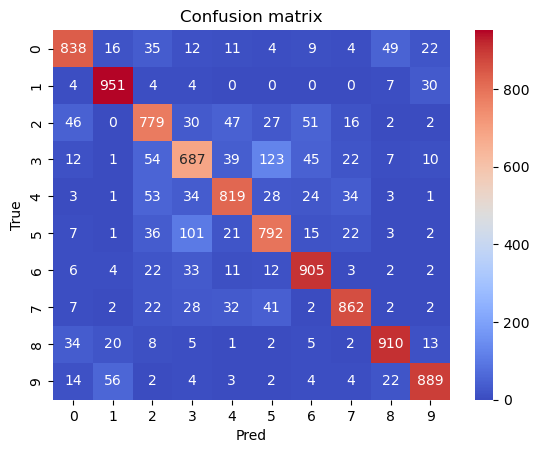

In [20]:
get_metrics(y_true, y_pred)